In [1]:
import pandas as pd
import numpy as np

#Modelisation
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars

#Fonction test model
#from Test_Model import test_model
#%matplotlib inline

from generation_tableau_rdts import generation_tableau_rdts

#Minimisation de la fonction objectif
from scipy.optimize import minimize

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# III/ Comparaison de l'erreur de prédiction de différentes méthodes statistiques

Jusqu'à maintenant, nous avons démontré que les stratégies d'investissements obtenues à partir de la résolution du problème de Markovitz (équivalent à la résolution d'un problème des moindres carrés => démonstration dans le fichier LaTeX) ne sont pas très convaincantes. Nous allons donc tester plusieurs autres méthodes statistiques de prédiction des rendements futurs et allons mettre en place une métrique commune qui mesure l'erreur de prédiction obtenue. 



Ici on crée l'interface qui nous permet de choisir le nombre d'actifs considéré, le nombre de dates, la vraie loi des rendements

In [2]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))
idx_date = pd.Index(np.arange(nb_dates))

esp_rdt = 0.05
vol_rdt = 0.2
correl = 0.7
seuil_pb_marko = 0.05
mu = pd.Series(esp_rdt,index=idx)
vols = pd.Series(vol_rdt,index=idx)
#Le vecteur constant cible que l'on essayer d'estimer -> chaque composante du vecteur est le rendement du protefeuille optimal tous  les jours
allocation_optimale_théorique = pd.Series(esp_rdt, index = idx_date)

#Matrice var-covar théorique selon la vraie loi des rendements
covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)

In [3]:
#On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
A = np.linalg.cholesky(covar)
rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

Ici on calcule les estimateurs d'espérance et de variance empiriques de la série des observations

In [4]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256

#Suivant la formule de la résolution du problème, on calcule l'allocation optimale "in sample"

covar_inv = np.linalg.inv(covar_estimee)
df_covar_inv = pd.DataFrame(covar_inv,index=idx,columns=idx)
lambda1 = seuil_pb_marko/(mu_estime @ df_covar_inv @ mu_estime)
alloc_optimale_in_sample = lambda1 * (df_covar_inv @ mu_estime)

A priori, nous pouvons nous ramener à la résolution d'un problème des moindres carrés. Donc nous allons effectuer la régression de la vraie allocation optimale sur les rendements observés. Le Beta que l'on obtient devrait être le plus proche possible de l'allocation optimale théorique. 

In [5]:
print(allocation_optimale_théorique)

0       0.05
1       0.05
2       0.05
3       0.05
4       0.05
        ... 
1275    0.05
1276    0.05
1277    0.05
1278    0.05
1279    0.05
Length: 1280, dtype: float64


In [6]:
regression = LinearRegression()

# Entraîner le modèle sur les données
regression.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients = regression.coef_
intercept = regression.intercept_

On réalise la régression sans intercept car la variable sur laquelle on régresse est colinéaire avec le vecteur constant égale à 1

In [7]:
regression_sans_intercept = LinearRegression(fit_intercept = False)

# Entraîner le modèle sur les données
regression_sans_intercept.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients_bis = regression_sans_intercept.coef_
intercept_bis = regression_sans_intercept.intercept_

On normalise le vecteur d'allocation entre les actifs in sample afin que la somme de ses poids soit égale à 1 et pareil pour le vecteur des coefficients qui sort de la régression sans intercept. 

On voit que l'on retrouve bien l'allocation in sample de la partie I. 

In [8]:
#Coefficients problème de Markovitz
alloc_optimale_in_sample_normalized = alloc_optimale_in_sample * (1 / sum(alloc_optimale_in_sample))
#Coefficients issues de la régression
coefficients_bis_normalized = coefficients_bis * (1 / sum(coefficients_bis))

print(alloc_optimale_in_sample_normalized - coefficients_bis_normalized)

0    -3.286260e-14
1     8.881784e-16
2     1.604272e-14
3    -3.830269e-15
4    -1.332268e-15
5     1.332268e-14
6     4.773959e-15
7     1.376677e-14
8     1.376677e-14
9    -1.535577e-14
10   -7.549517e-15
11    7.105427e-15
12    1.332268e-15
13    7.105427e-15
14   -4.174439e-14
15    2.842171e-14
16   -1.154632e-14
17    1.421085e-14
18   -5.329071e-15
19    1.776357e-15
dtype: float64


## A/ Régressions pénalisées

Dans cette partie, nous allons tester des régressions pénalisées afin de pouvoir comparer l'erreur de prédiction avec les précédentes méthodes

### 1/ Création des échantillons train/test

Ici, nous allons régresser le vecteur "allocation_optimale_theorique" qui est un vecteur colinéaire au vecteur constant égal à 1 et qui contient la performance, jour par jour, du portfolio optimal dans notre exemple

In [9]:
nb_dates_test = 256
nb_simu = 1000

In [10]:
X_train = rdts_observes
Y_train = allocation_optimale_théorique * 20

X_test = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
Y_test = allocation_optimale_théorique[:256] #Car les lois des actifs n'ont pas été modifiées

In [11]:
def test_model_NB(X_train, X_test, y_train, y_test, DF, model):
    """
    This function tests a given model using the provided training and testing data.
    
    Parameters:
    - X_train: The training data features.
    - X_test: The testing data features.
    - y_train: The training data labels.
    - y_test: The testing data labels.
    - DF: The DataFrame containing the feature names.
    - model: The model to be tested.
    
    Returns:
    - The allocation optimale according to the model.
    """
    
    # Run the model with the prebuilt functions
    ols = model.fit(X_train, y_train)
    y_pred = ols.predict(X_test)

    # Print the R^2 score of the model calculated from the training samples
    print("R_2 du modèle : " + str(ols.score(X_train, y_train)))
    print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, y_test)}")
    print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, y_test)}")

    # Create a DataFrame of the coefficients and sort them in ascending order
    coefs = pd.DataFrame(ols.coef_, columns=['Coefficients'], index=DF.columns)
    coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
    
    # Plot the coefficients
    coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
    plt.title('Régression linéaire')
    plt.axvline(x=0, color='1')
    plt.grid()
    plt.subplots_adjust(left=.3)

    return f"l'allocation optimale selon ce modèle est {ols.coef_}"

R_2 du modèle : 0.0
Le MSE (Mean Squared Error) de notre prédiction est de 0.013659620816278417
Le MAE (Mean Absolute Error) de notre prédiction est de 0.0927799468948477


"l'allocation optimale selon ce modèle est [ 6.88245009  1.67076996  0.40053098 -0.06787037 -1.17193637 -3.33906609\n -0.96554557 -2.11086018 -3.39577515 -0.03323088  3.01179579 -4.11394731\n -2.29732287 -3.44481141  5.6479723  -4.93328791  3.88243502  4.11244368\n  4.35545838 -3.07345317]"

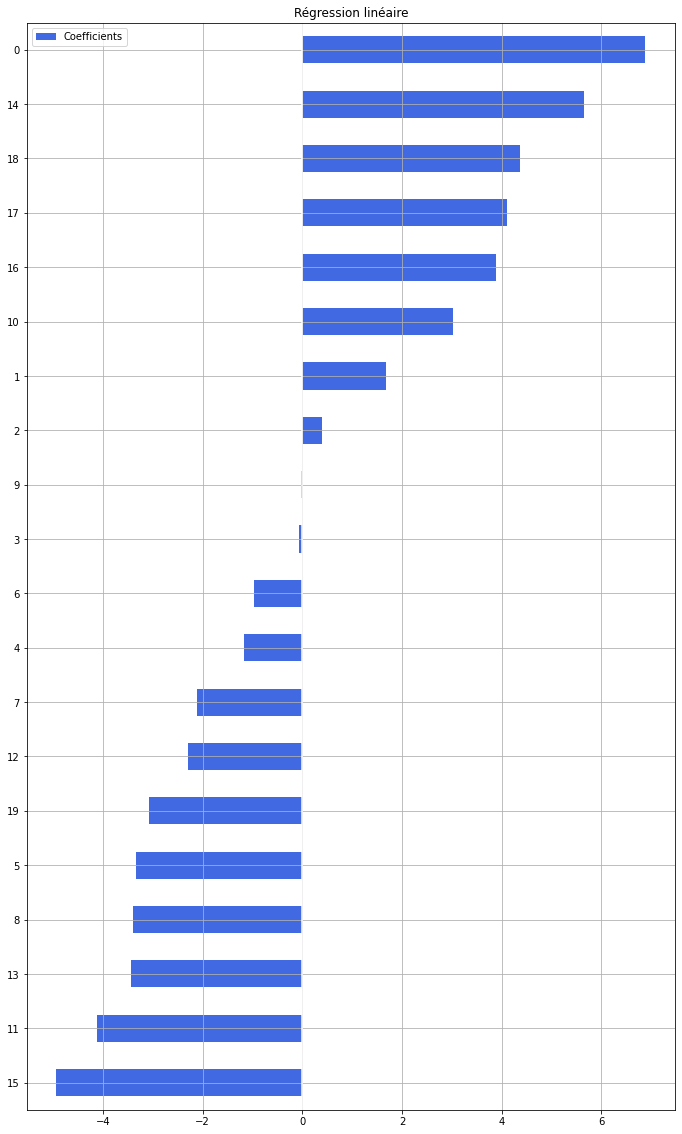

In [12]:
test_model_NB(X_train, X_test, Y_train, Y_test, X_train, LinearRegression(fit_intercept = False))

Le MSE (Mean Squared Error) de notre prédiction est de 0.013659620816278417
Le MAE (Mean Absolute Error) de notre prédiction est de 0.0927799468948477
[ 6.76907558  1.64324739  0.39393304 -0.06675235 -1.15263108 -3.2840617
 -0.94964015 -2.07608801 -3.33983659 -0.03268347  2.96218251 -4.04617831
 -2.2594791  -3.38806507  5.55493333 -4.85202192  3.81847971  4.04469944
  4.28371097 -3.02282422]


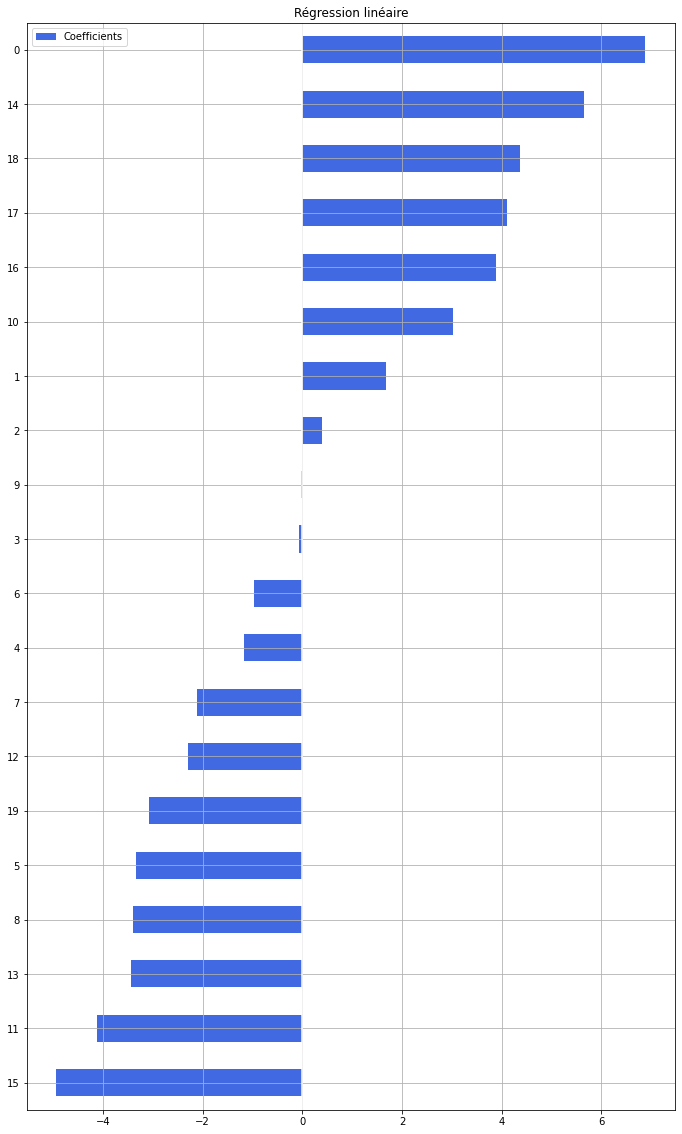

In [13]:
reg = LinearRegression(fit_intercept = False)
model =  reg.fit(X_train, Y_train)
coef_reglin = model.coef_
y_pred = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, Y_test)}")

coefs = pd.DataFrame(coef_reglin, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_reg_lin_normalized = coef_reglin * abs(1/sum(coef_reglin))
print(coef_reg_lin_normalized)

On affiche les PNL in sample

Sharpe = 1.70372078128162


<AxesSubplot:>

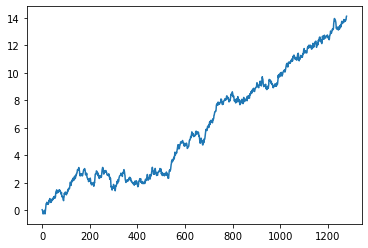

In [14]:
pnl_in_sample_reglin = rdts_observes @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16))
pnl_in_sample_reglin.cumsum().plot()

Maintenant, testons les 2 portefeuilles out-sample

Sharpe = -0.4110173853569839


<AxesSubplot:>

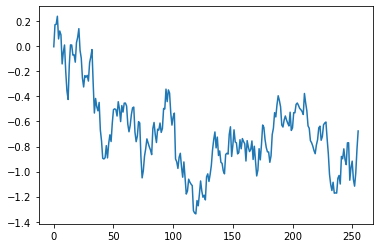

In [15]:
pnl_test_reglin = X_test @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_test_reglin.mean()/pnl_test_reglin.std()*16))
pnl_test_reglin.cumsum().plot()

Maintenant, nous allons simuler plusieurs échantillons test et voir, en moyenne, comment se comporte notre portefeuille

In [16]:
pnl_out_sample_reglin = []
sharpe_out_sample_reglin = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_reg_lin_normalized
    pnl_out_sample_reglin.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_reglin.append(sharpe_simu)

sharpe_out_sample_DF_reglin = pd.DataFrame(sharpe_out_sample_reglin)
sharpe_out_sample_DF_reglin.describe()
    

,0
count,1000.000000
mean,-0.012883
std,1.013551
min,-3.051720
25%,-0.715644
50%,0.007634
75%,0.680192
max,3.509855


On affiche les quantiles des sharpe ratio de toutes nos simulations et on trace la moyenne afin de voir le sharpe moyen que nous apporte notre portfolio

Voici le sharpe moyen de cette méthode -0.012883498519201873


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_9450/2877958211.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())


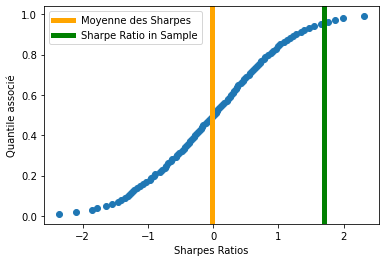

In [17]:
quantiles = sharpe_out_sample_DF_reglin.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())
sharpe_in_sample = pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
#plt.scatter(quantiles['quantile']*0 + sharpe_out_sample_DF.mean(),quantiles['proba'])
#plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Désormais, nous allons faire la même chose avec les régressions pénalisées

Le MSE (Mean Squared Error) de notre prédiction est de 0.013659620816278417
Le MAE (Mean Absolute Error) de notre prédiction est de 0.0927799468948477
[ 2.62228393  0.80506875  0.20936934  0.06999416 -0.34441063 -1.09424423
 -0.37305917 -0.69527345 -1.18740913 -0.03502498  1.0913075  -1.8249005
 -0.8425445  -1.33849703  2.15105891 -1.70977158  1.31945603  1.72983527
  1.73681474 -1.29005343]


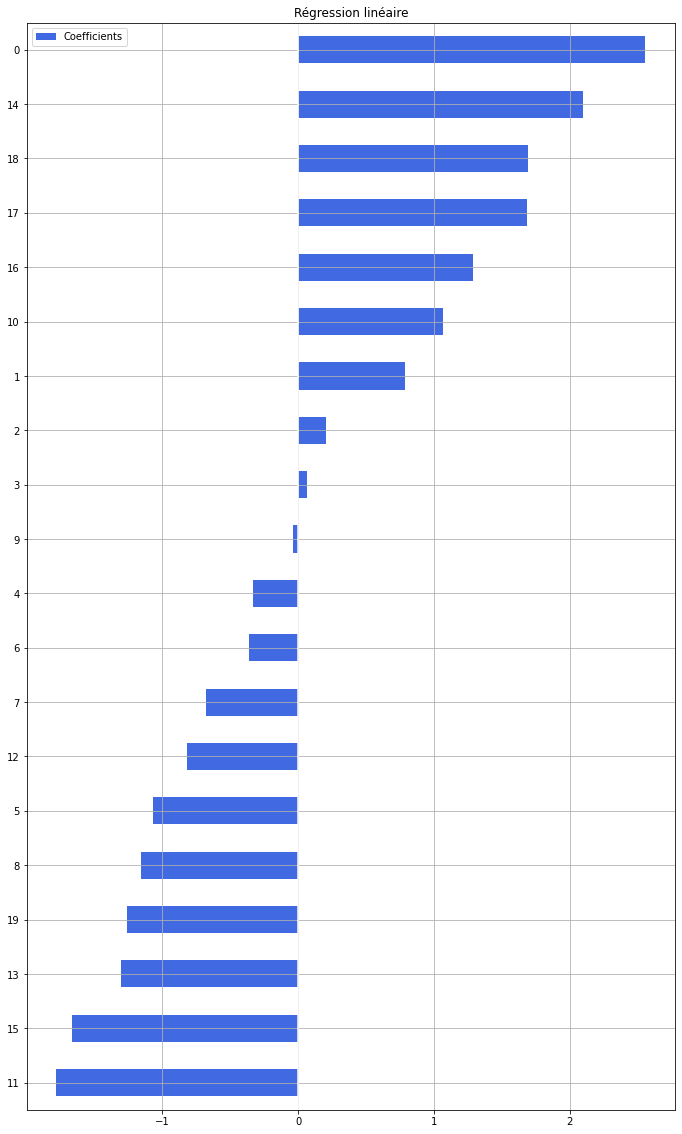

In [18]:
ridge = RidgeCV(fit_intercept = False, cv = 5)
model_ridge =  ridge.fit(X_train, Y_train)
coef_ridge = model_ridge.coef_
y_pred_ridge = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred_ridge, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred_ridge, Y_test)}")

coefs = pd.DataFrame(coef_ridge, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_ridge_normalized = coef_ridge * abs(1/sum(coef_ridge))
print(coef_ridge_normalized)

Sharpe = 1.6791002566734257


<AxesSubplot:>

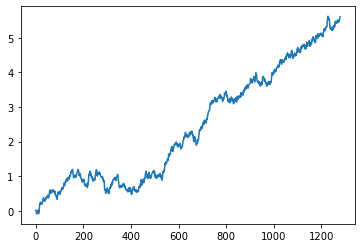

In [19]:
pnl_in_sample_ridge = rdts_observes @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16))
pnl_in_sample_ridge.cumsum().plot()

Sharpe = -0.3595223426013362


<AxesSubplot:>

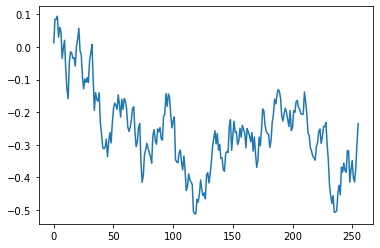

In [20]:
pnl_test_ridge = X_test @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_test_ridge.mean()/pnl_test_ridge.std()*16))
pnl_test_ridge.cumsum().plot()

In [21]:
pnl_out_sample_ridge = []
sharpe_out_sample_ridge = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_ridge_normalized
    pnl_out_sample_ridge.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_ridge.append(sharpe_simu)

sharpe_out_sample_DF_ridge = pd.DataFrame(sharpe_out_sample_ridge)
sharpe_out_sample_DF_ridge.describe()

,0
count,1000.000000
mean,0.099922
std,0.979114
min,-2.995006
25%,-0.566231
50%,0.074459
75%,0.801625
max,2.986065


Voici le sharpe moyen de cette méthode 0.09992168896809336


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_9450/3976622379.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())


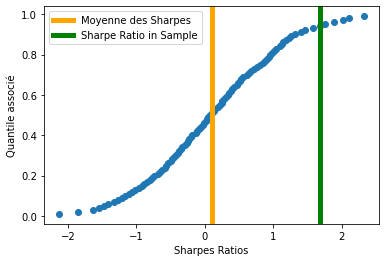

In [22]:
quantiles = sharpe_out_sample_DF_ridge.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())
sharpe_in_sample = pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Pareil avec le LASSO. On utilise Lasso() et non LassoCV() car la pénalisation choisie est trop forte et mène à ne choisir d'investir dans aucun actif

[ 3.85352747  0.          0.         -0.         -0.         -0.99604747
 -0.         -0.0468151  -1.20174537 -0.          0.18030572 -2.47162293
 -0.31387282 -1.42415736  2.74306913 -2.31593224  0.73569325  1.81893014
  1.7612496  -1.32258203]


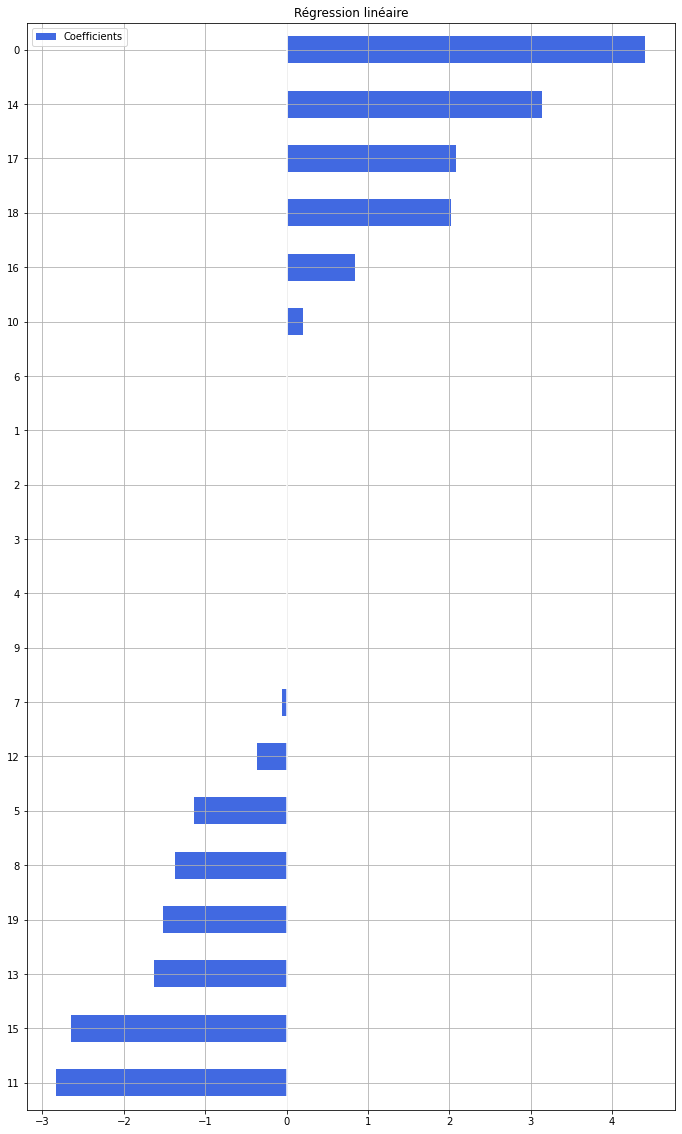

In [23]:
lasso = Lasso(fit_intercept = False, alpha = 0.0001)
model_lasso =  lasso.fit(X_train, Y_train)
coef_lasso = model_lasso.coef_

coefs = pd.DataFrame(coef_lasso, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_lasso_normalized = coef_lasso * abs(1/sum(coef_lasso))
print(coef_lasso_normalized)

Sharpe = 1.5941762960515944


<AxesSubplot:>

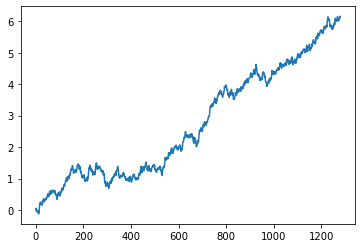

In [24]:
pnl_in_sample_lasso = rdts_observes @ coef_lasso_normalized
print('Sharpe = ' + str(pnl_in_sample_lasso.mean()/pnl_in_sample_lasso.std()*16))
pnl_in_sample_lasso.cumsum().plot()

Sharpe = -0.4031873399225751


<AxesSubplot:>

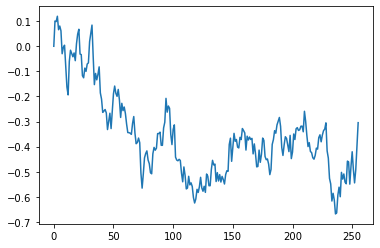

In [25]:
pnl_test_lasso = X_test @ coef_lasso_normalized
print('Sharpe = ' + str(pnl_test_lasso.mean()/pnl_test_lasso.std()*16))
pnl_test_lasso.cumsum().plot()

In [26]:
pnl_out_sample_lasso = []
sharpe_out_sample_lasso = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_lasso_normalized
    pnl_out_sample_lasso.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_lasso.append(sharpe_simu)

sharpe_out_sample_DF_lasso = pd.DataFrame(sharpe_out_sample_lasso)
sharpe_out_sample_DF_lasso.describe()

,0
count,1000.000000
mean,0.047318
std,1.010393
min,-3.347686
25%,-0.620642
50%,0.030272
75%,0.706429
max,3.770888


Voici le sharpe moyen de cette méthode 0.04731806332507983


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_9450/3749574625.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_lasso.mean())


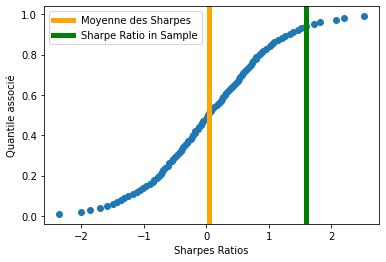

In [27]:
quantiles = sharpe_out_sample_DF_lasso.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_lasso.mean())
sharpe_in_sample = pnl_in_sample_lasso.mean()/pnl_in_sample_lasso.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Comparaison des coefficients obtenus avec la régression classique et la régression Ridge/LASSO (normalisés)

In [28]:
print(coef_reg_lin_normalized)
print(coef_ridge_normalized)
print(coef_lasso_normalized)

[ 6.76907558  1.64324739  0.39393304 -0.06675235 -1.15263108 -3.2840617
 -0.94964015 -2.07608801 -3.33983659 -0.03268347  2.96218251 -4.04617831
 -2.2594791  -3.38806507  5.55493333 -4.85202192  3.81847971  4.04469944
  4.28371097 -3.02282422]
[ 2.62228393  0.80506875  0.20936934  0.06999416 -0.34441063 -1.09424423
 -0.37305917 -0.69527345 -1.18740913 -0.03502498  1.0913075  -1.8249005
 -0.8425445  -1.33849703  2.15105891 -1.70977158  1.31945603  1.72983527
  1.73681474 -1.29005343]
[ 3.85352747  0.          0.         -0.         -0.         -0.99604747
 -0.         -0.0468151  -1.20174537 -0.          0.18030572 -2.47162293
 -0.31387282 -1.42415736  2.74306913 -2.31593224  0.73569325  1.81893014
  1.7612496  -1.32258203]


### B/Changements des paramètres et impact sur le sharpe ratio

Création fonction qui génère le tableau des rendements en ayant la possibilité de changer les paramètres :
- Nombre d'actifs
- Nombre de dates
- Nombre de sous classes d'actifs avec leurs lois

Pour harmoniser les tests, on va fixer une graîne de manière à avoir un échantillon plus parlant : 

In [29]:
np.random.seed(10)

Testons la régression LARSE

Voici le sharpe moyen de cette méthode 0.083


/Users/tomrossa/Documents/ENSAE/Projet StatApp/StatApp_M1_ENSAE/Brouillon_Tom/generation_tableau_rdts.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 1.21002838 11.6027298  -1.98194975 -5.54959484  8.96006384 -3.38313978\n -2.89924178 -2.92709288  2.90760389 -4.33227509  0.98561956  1.6235821\n -4.01587729  0.37943939 -5.1274947  -2.79679851 -2.93992374  2.15917133\n  3.22941608  6.6371093 ]'

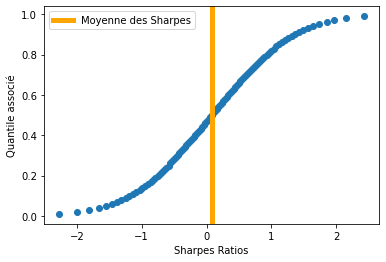

In [30]:
generation_tableau_rdts(20, 256*5, [0.05], [0.2], 25000, 256,0.7, Lars(fit_intercept=False))

Nous pouvons désormais faire varier les différents paramètres, complexifier les lois des différents actifs et comparer les sharpes moyen des différentes méthodes. 

In [31]:
generation_tableau_rdts(9, 10000, [0.05, 0.03, 0.1], [0.2, 0.15, 0.3], 1000, 256, Lasso(fit_intercept=False, alpha = 0.0001))

TypeError: generation_tableau_rdts() missing 1 required positional argument: 'model'

Nous allons tester méthodiquement l'impact de la variation des différents paramètres sur le sharpe ratio out sample. Tout d'abord, faisons varier le nombre d'actifs. 

Voici le sharpe moyen de cette méthode 0.065


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_83732/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-1.67059737 -1.36823463  2.55953597  0.06630193 -1.92138642  0.26306482\n  2.76084002  0.99340068 -1.05664054]'

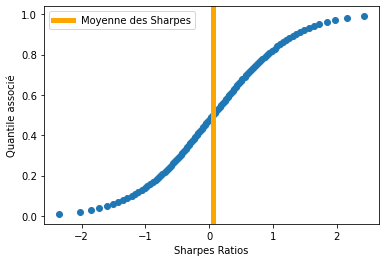

In [ ]:
generation_tableau_rdts(9, 256*5, [0.05], [0.2], 10000, 256, RidgeCV(fit_intercept=False, cv = 5))

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_83732/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


Voici le sharpe moyen de cette méthode 0.215


'Voici le portfolio optimal selon cette méthode : [ 1.07659612  0.92826437  2.44228253 -0.67120076  1.15215829  0.14871756\n  0.39686004  1.17127977  1.98412876 -0.25881666  1.32509809 -2.23443387\n -0.12776451 -2.98872618  0.56403449 -1.3688248  -0.45550589  0.90725338]'

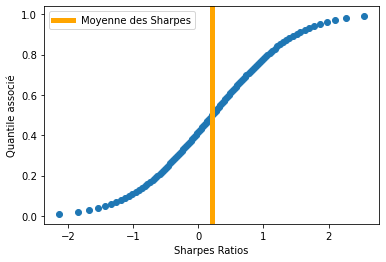

In [ ]:
generation_tableau_rdts(18, 256*5, [0.05], [0.2], 70000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode -0.126


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_83732/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-2.22806537  0.84112068 -1.32546651 -1.29224963 -1.52059891 -0.52381339\n  0.13846091  0.21418169  1.69188906  0.27219744 -1.86459568  0.51370534\n  0.62533259  0.73172013  2.00769095 -0.88647482 -0.32555088 -2.95906113\n  1.35115489  0.64491416 -0.27774364  2.7291302   0.14013823 -0.17001175\n  1.55822828 -0.5620813   0.08255913 -0.24482995 -1.31442516 -0.14645591]'

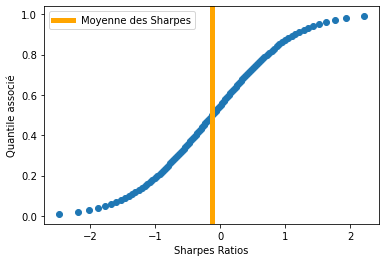

In [ ]:
generation_tableau_rdts(30, 256*5, [0.05], [0.2], 80000, 256, RidgeCV(fit_intercept=False, cv = 5))

Maintenant, nous allons faire varier le nombre de dates d'historique utilisé : 1 an puis 10 ans d'historique d'entrainement

Voici le sharpe moyen de cette méthode -0.287


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_83732/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-1.88727792 -1.20675043  0.34389639 -1.47560032 -1.8027379  -0.54761655\n -0.25484339 -1.12286251  0.4544433 ]'

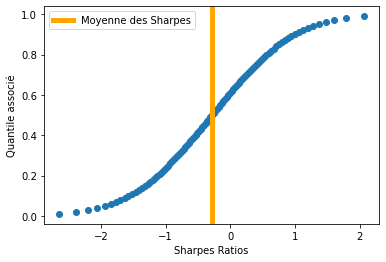

In [ ]:
generation_tableau_rdts(9, 256, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode -0.176


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_83732/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.56783546 -2.06431939  2.45014451 -0.24808043 -0.4676893  -0.74673532\n -0.86811993  1.1457458  -0.28865024  0.50871843 -0.22831857  0.09017653\n -0.97568123 -0.70910546  0.57666207 -2.40376409 -0.24790604  0.21767818\n -0.06759738  0.01698216 -0.13149888  0.65293027 -0.3196955   1.25430929\n -0.52760002 -0.52385905 -0.57384883  1.01025004  0.5398939  -0.07440059]'

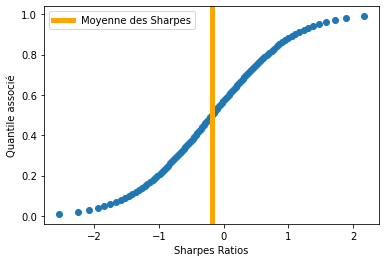

In [ ]:
generation_tableau_rdts(30, 256, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

In [ ]:
generation_tableau_rdts(9, 256*10, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

KeyboardInterrupt: 

Voici le sharpe moyen de cette méthode 0.21


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_80254/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-1.84943829 -1.1156043   0.49828268  2.30559432  0.45376814  2.95001461\n  0.5627905  -0.5190842   0.25329407  0.11438787  1.37036205  0.03042809\n -0.79974321 -0.39573889 -0.73911262  0.83898945  1.6510591  -0.56773977\n  0.60779818  0.24164914 -1.61048464  1.76789203  1.57070966  1.02663333\n -1.94368603 -0.29687055  2.2660793  -1.36777647 -2.00586157 -0.77514924]'

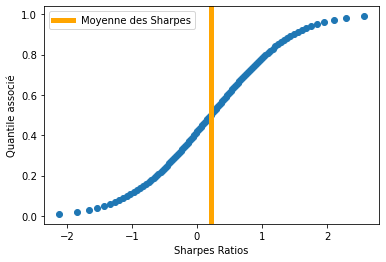

In [ ]:
generation_tableau_rdts(30, 256*10, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Enfin, nous allons faire varier les lois des actifs en les scidant en deux groupes : Deux niveaux de rendements distincts pour la même variance et 2 niveaux de variance distincts pour le même rendement. 

Voici le sharpe moyen de cette méthode 0.574


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_80254/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.44729078 -1.19915363 -1.7413813  -0.35562067 -0.24028512  0.03041234\n -3.68583797 -1.16106007 -2.90344236  0.70861303  3.03831715  2.37196055\n  0.65809391  2.66390107 -1.12503958  0.27223648  1.61867627  1.38863849]'

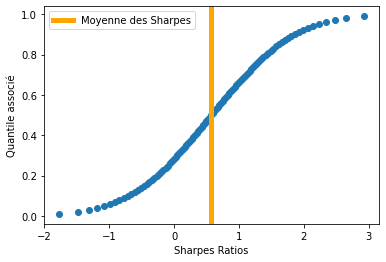

In [ ]:
generation_tableau_rdts(18, 256*10, [0.02, 0.06], [0.2, 0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode 0.472


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_80254/2608235390.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.25953258  1.18138612 -2.84313082 -0.72143169 -0.99384456  0.36110329\n  0.53889398  0.04766309  2.49149261  1.70655814  1.36528794  0.91876761\n  0.81053186 -0.99943147 -1.14222917  1.78192126  0.02576175  0.32115872]'

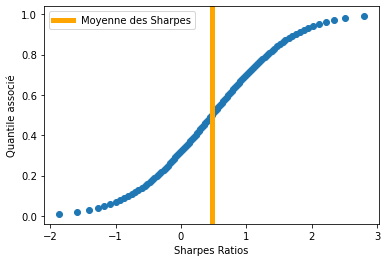

In [ ]:
generation_tableau_rdts(18, 256*10, [0.05], [0.1, 0.3], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

### B.BIS/ Mesure de l'overfitting des différents modèles de régressions pénalisées

On va tenter une approche plus propre pour le test de variation des paramètres. Créons une fonction dont l'unique objet est de générer la matrice de rendements avec les différents paramètres qui nous intéressent.
En l'occurence ici, la fonction permet de modifier le nombre d'actifs, la taille de l'historique sur lequel on va entraîner le modèle et les vecteurs permettant de générer rendements des actifs selon les lois que l'on souhaite. 
On ajoute la possibilité de modifier la corrélation entre les actifs mais qui doit rester constante pour tous. 

In [ ]:
def rdt_matrix_generator(nb_actifs, nb_dates, list_esp_rdts, list_vols, correl) :     
    #Définition des lois des actifs
    idx = pd.Index(np.arange(nb_actifs))
    idx_date = pd.Index(np.arange(nb_dates))
    mu = np.zeros(nb_actifs)
    nb = len(list_esp_rdts)
    vol = np.zeros(nb_actifs)

    for i in range(nb):
        valeur_commune_mu = list_esp_rdts[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        mu[debut_bloc:fin_bloc] = valeur_commune_mu
    
    for i in range(nb):
        valeur_commune_vol = list_vols[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        vol[debut_bloc:fin_bloc] = valeur_commune_vol

    #correl = 0.7

    #Matrice var-covar théorique selon la vraie loi des rendements
    covar = np.diag(vol) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vol)

    #On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
    A = np.linalg.cholesky(covar)
    rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

    return rdts_observes

Désormais, nous allons nous placer dans le cas 1) où tous les actifs suivent la même loi. Nous allons tester et afficher le graphique de l'évolution des sharpes ratios in et out sample en fonction de la variation de tous ces paramètres. Nous afficherons aussi le sharpe ratio du portefeuille optimal théorique. 

Les paramètres qui varieront : 
- Nombre d'actifs
- Nombre de dates dans l'échantillon d'entraînement
- Espérance des rendements (constante pour tous)
- Variance des rendements (constante)
- Corrélation entre les actifs
- Ratio Nombre de lignes / Nombre de colonnes dans la matrice des rendements

#### B.1/ Variation du nombre d'actifs

Pour avoir des résultats satisfaisant on entraîne le modèle sur 10 ans d'historique et on va tracer la courbe pour un nombre d'actifs qui varie entre 1 et 60. Pour ce qui est de loi des actifs on garde celle de l'exemple initial. 

On commence avec la régression simple. 

In [ ]:
nb_dates = 256*10
nb_actifs_max = 60
idx_date = pd.Index(np.arange(nb_dates))
Y_train = pd.Series(1, index = idx_date)
vol = [0.2]
correl = 0.7
esp = [0.05]

#Paramètres pour l'échantillon de test
nb_dates_test = 256 #On va tester sur 1 an au début
nb_simu = 1000

In [ ]:
model = LinearRegression(fit_intercept=False)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []

for i in range(2, nb_actifs_max) : 
    rdts = rdt_matrix_generator(i, nb_dates, esp, vol, correl)
    model_ =  model.fit(rdts, Y_train)
    coeffs = model_.coef_

    #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coeffs
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)

    #On calcule les sharpes du portfolio optimal théorique
    portfolio_opti_theo = 1/i * np.ones(i)

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    #coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #On doit refaire le calcul pour générer les simus
    idx1 = pd.Index(np.arange(i))
    mu = pd.Series(esp[0],index=idx1)
    vols = pd.Series(vol[0],index=idx1)
    covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((i,i)) + (1-correl) * np.eye(i),index=idx1,columns=idx1) @ np.diag(vols)
    A = np.linalg.cholesky(covar)

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0
    for j in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test, i)) @ A.T / 16
        pnl_simu = simu @ coeffs
        pnl_theo = simu @ portfolio_opti_theo
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
        sharpe_opti_simu = pnl_theo.mean() / pnl_theo.std() * 16
        sharpe_opti_ += sharpe_opti_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)
    sharpe_opti_theo.append(sharpe_opti_ / nb_simu)

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

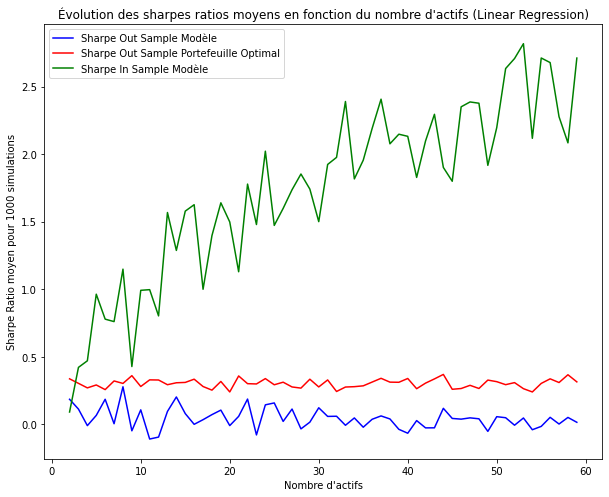

In [ ]:
x = range(2, 60)

plt.figure(figsize=(10, 8))

plt.plot(x, sharpes_mean, label = 'Sharpe Out Sample Modèle', color = 'blue')
plt.plot(x, sharpe_opti_theo, label = 'Sharpe Out Sample Portefeuille Optimal', color = 'red')
plt.plot(x, sharpe_in_sample_, label = 'Sharpe In Sample Modèle', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens en fonction du nombre d'actifs (Linear Regression)")
plt.xlabel("Nombre d'actifs")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')


Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

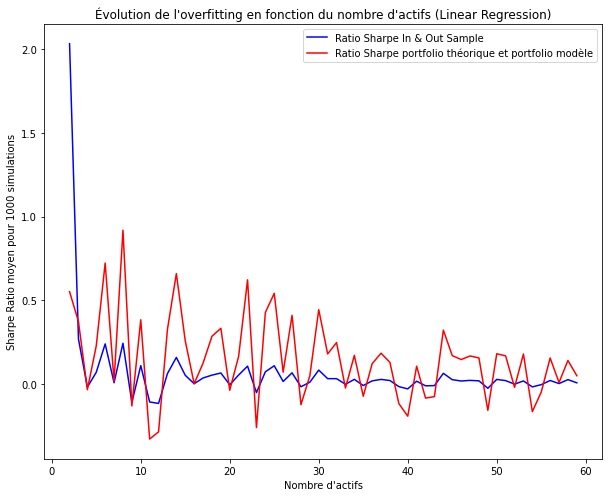

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(x, np.array(sharpes_mean) / np.array(sharpe_in_sample_), label = 'Ratio Sharpe In & Out Sample', color = 'blue')
plt.plot(x, np.array(sharpes_mean) / np.array(sharpe_opti_theo), label = 'Ratio Sharpe portfolio théorique et portfolio modèle', color = 'red')
plt.legend()

plt.title("Évolution de l'overfitting en fonction du nombre d'actifs (Linear Regression)")
plt.xlabel("Nombre d'actifs")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

On va faire exactement la même chose pour le Ridge et le Lasso : 

In [ ]:
model = RidgeCV(fit_intercept=False, cv = 5)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []

for i in range(2, nb_actifs_max) : 
    rdts = rdt_matrix_generator(i, nb_dates, esp, vol, correl)
    model_ =  model.fit(rdts, Y_train)
    coeffs = model_.coef_

    #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coeffs
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)

    #On calcule les sharpes du portfolio optimal théorique
    portfolio_opti_theo = 1/i * np.ones(i)

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    #coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #On doit refaire le calcul pour générer les simus
    idx1 = pd.Index(np.arange(i))
    mu = pd.Series(esp[0],index=idx1)
    vols = pd.Series(vol[0],index=idx1)
    covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((i,i)) + (1-correl) * np.eye(i),index=idx1,columns=idx1) @ np.diag(vols)
    A = np.linalg.cholesky(covar)

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0
    for j in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test, i)) @ A.T / 16
        pnl_simu = simu @ coeffs
        pnl_theo = simu @ portfolio_opti_theo
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
        sharpe_opti_simu = pnl_theo.mean() / pnl_theo.std() * 16
        sharpe_opti_ += sharpe_opti_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)
    sharpe_opti_theo.append(sharpe_opti_ / nb_simu)

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

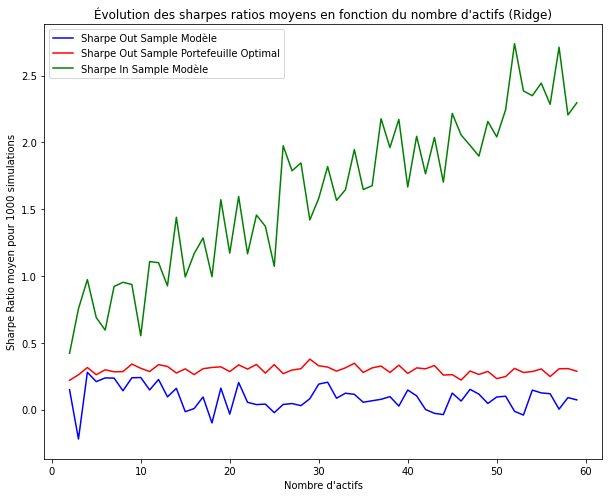

In [ ]:
x = range(2, 60)

plt.figure(figsize=(10, 8))

plt.plot(x, sharpes_mean, label = 'Sharpe Out Sample Modèle', color = 'blue')
plt.plot(x, sharpe_opti_theo, label = 'Sharpe Out Sample Portefeuille Optimal', color = 'red')
plt.plot(x, sharpe_in_sample_, label = 'Sharpe In Sample Modèle', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens en fonction du nombre d'actifs (Ridge)")
plt.xlabel("Nombre d'actifs")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

Pour mesurer l'over-fitting du modèle on va plutôt considérer les VALEURS ABSOLUES des ratios des sharpes-out sample / sharpe-in sample. Plus ce ratio est faible plus cela signifie que l'écart relatifs entre les sharpes out-sample et in sample est élevé et donc on peut considérer que le modèle overfit. 

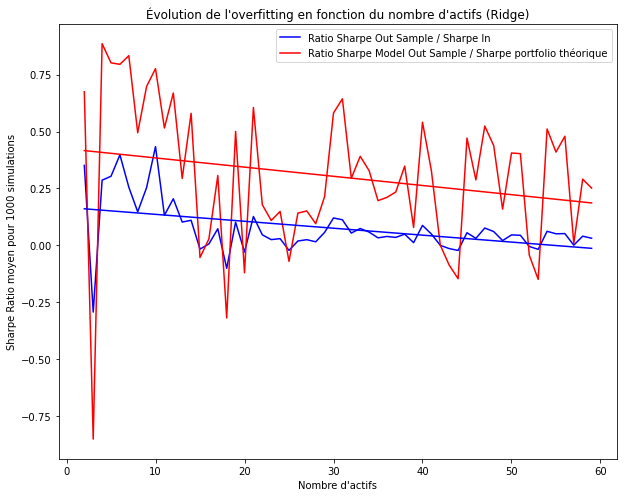

In [ ]:
plt.figure(figsize=(10, 8))

x = np.array(x).reshape(-1, 1)
y1 = (np.array(sharpes_mean) / np.array(sharpe_in_sample_))
y2 = np.array(sharpes_mean) / np.array(sharpe_opti_theo)

plt.plot(x, y1, label = 'Ratio Sharpe Out Sample / Sharpe In', color = 'blue')
plt.plot(x, y2, label = 'Ratio Sharpe Model Out Sample / Sharpe portfolio théorique', color = 'red')
plt.legend()

plt.title("Évolution de l'overfitting en fonction du nombre d'actifs (Ridge)")
plt.xlabel("Nombre d'actifs")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

#ON peut plot les droites des MCO rouge et bleue pour montrer la tendance de l'overfitting avec le paramètres;
model_overfitting = LinearRegression()
MCO1 = model_overfitting.fit(x, y1)
slope = MCO1.coef_
intercept = MCO1.intercept_
plt.plot(x, slope*x + intercept, color = 'blue')

MCO2 = model_overfitting.fit(x, y2)
slope = MCO1.coef_
intercept = MCO1.intercept_
plt.plot(x, slope*x + intercept, color = 'red')

#### B.2/ Variation du nombre de dates d'entraînement

In [ ]:
nb_dates_max = 256*25
nb_actifs_ = 20
vol = [0.2]
correl = 0.7
esp = [0.05]

#Paramètres pour l'échantillon de test
nb_dates_test = 256 #On va tester sur 1 an au début
nb_simu = 1000

In [ ]:
model = LinearRegression(fit_intercept=False)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []
portfolio_opti_theo = 1/20 * np.ones(20)

for i in range(100, nb_dates_max, 64) :
    idx_date = pd.Index(np.arange(i))
    Y_train = pd.Series(1, index = idx_date) 
    rdts = rdt_matrix_generator(nb_actifs_, i, esp, vol, correl)
    model_ =  model.fit(rdts, Y_train)
    coeffs = model_.coef_

    #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coeffs
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    #coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #On doit refaire le calcul pour générer les simus
    idx1 = pd.Index(np.arange(nb_actifs_))
    mu = pd.Series(esp[0],index=idx1)
    vols = pd.Series(vol[0],index=idx1)
    covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs_,nb_actifs_)) + (1-correl) * np.eye(nb_actifs_),index=idx1,columns=idx1) @ np.diag(vols)
    A = np.linalg.cholesky(covar)

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0
    for j in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test, nb_actifs_)) @ A.T / 16
        pnl_simu = simu @ coeffs
        pnl_theo = simu @ portfolio_opti_theo
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
        sharpe_opti_simu = pnl_theo.mean() / pnl_theo.std() * 16
        sharpe_opti_ += sharpe_opti_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)
    sharpe_opti_theo.append(sharpe_opti_ / nb_simu)

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

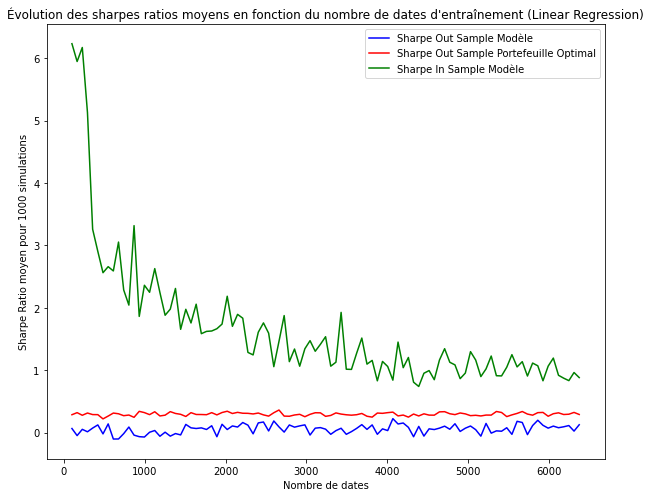

In [ ]:
x = range(100, nb_dates_max, 64)

plt.figure(figsize=(10, 8))

plt.plot(x, sharpes_mean, label = 'Sharpe Out Sample Modèle', color = 'blue')
plt.plot(x, sharpe_opti_theo, label = 'Sharpe Out Sample Portefeuille Optimal', color = 'red')
plt.plot(x, sharpe_in_sample_, label = 'Sharpe In Sample Modèle', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens en fonction du nombre de dates d'entraînement (Linear Regression)")
plt.xlabel("Nombre de dates")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

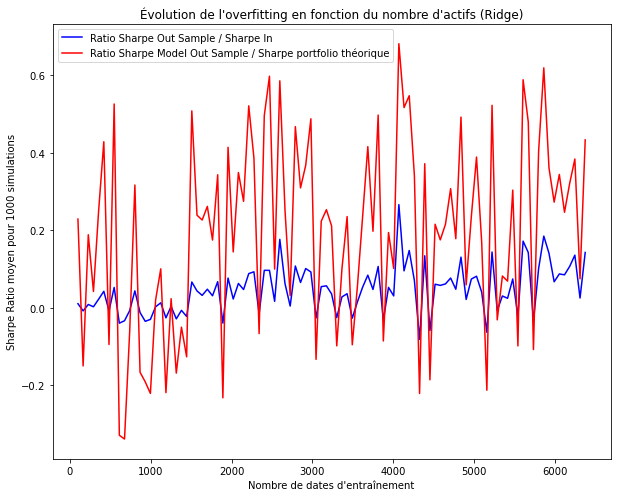

In [ ]:
plt.figure(figsize=(10, 8))

y1 = (np.array(sharpes_mean) / np.array(sharpe_in_sample_))
y2 = np.array(sharpes_mean) / np.array(sharpe_opti_theo)

plt.plot(x, y1, label = 'Ratio Sharpe Out Sample / Sharpe In', color = 'blue')
plt.plot(x, y2, label = 'Ratio Sharpe Model Out Sample / Sharpe portfolio théorique', color = 'red')
plt.legend()

plt.title("Évolution de l'overfitting en fonction du nombre d'actifs (Ridge)")
plt.xlabel("Nombre de dates d'entraînement")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

Pareil encore avec le Ridge : 

In [ ]:
model = RidgeCV(fit_intercept=False, cv=5)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []
portfolio_opti_theo = 1/20 * np.ones(20)

for i in range(100, nb_dates_max, 64) :
    idx_date = pd.Index(np.arange(i))
    Y_train = pd.Series(1, index = idx_date) 
    rdts = rdt_matrix_generator(nb_actifs_, i, esp, vol, correl)
    model_ =  model.fit(rdts, Y_train)
    coeffs = model_.coef_

    #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coeffs
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    #coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #On doit refaire le calcul pour générer les simus
    idx1 = pd.Index(np.arange(nb_actifs_))
    mu = pd.Series(esp[0],index=idx1)
    vols = pd.Series(vol[0],index=idx1)
    covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs_,nb_actifs_)) + (1-correl) * np.eye(nb_actifs_),index=idx1,columns=idx1) @ np.diag(vols)
    A = np.linalg.cholesky(covar)

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0
    for j in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test, nb_actifs_)) @ A.T / 16
        pnl_simu = simu @ coeffs
        pnl_theo = simu @ portfolio_opti_theo
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
        sharpe_opti_simu = pnl_theo.mean() / pnl_theo.std() * 16
        sharpe_opti_ += sharpe_opti_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)
    sharpe_opti_theo.append(sharpe_opti_ / nb_simu)

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

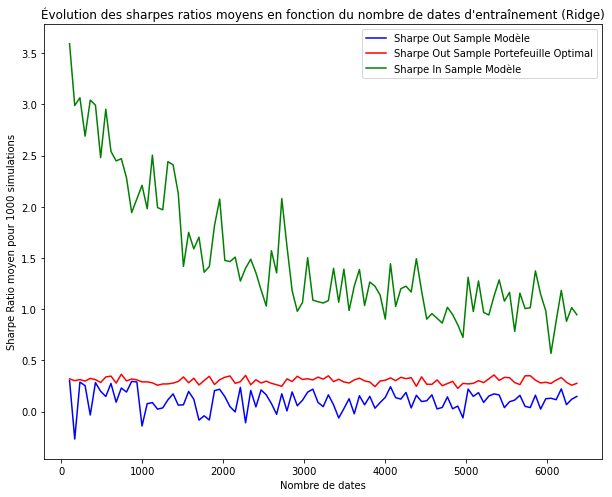

In [ ]:
x = range(100, nb_dates_max, 64)

plt.figure(figsize=(10, 8))

plt.plot(x, sharpes_mean, label = 'Sharpe Out Sample Modèle', color = 'blue')
plt.plot(x, sharpe_opti_theo, label = 'Sharpe Out Sample Portefeuille Optimal', color = 'red')
plt.plot(x, sharpe_in_sample_, label = 'Sharpe In Sample Modèle', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens en fonction du nombre de dates d'entraînement (Ridge)")
plt.xlabel("Nombre de dates")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

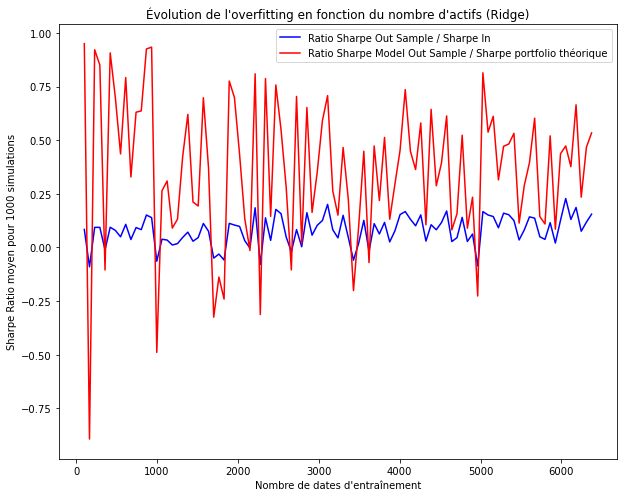

In [ ]:
plt.figure(figsize=(10, 8))

y1 = (np.array(sharpes_mean) / np.array(sharpe_in_sample_))
y2 = np.array(sharpes_mean) / np.array(sharpe_opti_theo)

plt.plot(x, y1, label = 'Ratio Sharpe Out Sample / Sharpe In', color = 'blue')
plt.plot(x, y2, label = 'Ratio Sharpe Model Out Sample / Sharpe portfolio théorique', color = 'red')
plt.legend()

plt.title("Évolution de l'overfitting en fonction du nombre d'actifs (Ridge)")
plt.xlabel("Nombre de dates d'entraînement")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

#### B.3/ Variation des paramètres des lois des actifs 

On va rester dans le même cas de figure mais faire varier l'espérance et la volatilité des actifs 

In [ ]:
nb_dates = 256*10
nb_actifs_ = 20
vol = [0.2]
correl = 0.7
idx_date = pd.Index(np.arange(nb_dates))
Y_train = pd.Series(1, index = idx_date)

#Paramètres pour l'échantillon de test
nb_dates_test = 256 #On va tester sur 1 an au début
nb_simu = 1000

In [ ]:
model = LinearRegression(fit_intercept=False)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []
portfolio_opti_theo = 1/20 * np.ones(20)

for i in range(0, 1, 0.005) :
    rdts = rdt_matrix_generator(nb_actifs_, nb_dates, i, vol, correl)
    model_ =  model.fit(rdts, Y_train)
    coeffs = model_.coef_

    #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coeffs
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    #coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #On doit refaire le calcul pour générer les simus
    idx1 = pd.Index(np.arange(nb_actifs_))
    mu = pd.Series(i,index=idx1)
    vols = pd.Series(vol[0],index=idx1)
    covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs_,nb_actifs_)) + (1-correl) * np.eye(nb_actifs_),index=idx1,columns=idx1) @ np.diag(vols)
    A = np.linalg.cholesky(covar)

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0
    for j in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test, nb_actifs_)) @ A.T / 16
        pnl_simu = simu @ coeffs
        pnl_theo = simu @ portfolio_opti_theo
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
        sharpe_opti_simu = pnl_theo.mean() / pnl_theo.std() * 16
        sharpe_opti_ += sharpe_opti_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)
    sharpe_opti_theo.append(sharpe_opti_ / nb_simu)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
x = range(0.01, 0.5, 0.005)

plt.figure(figsize=(10, 8))

plt.plot(x, sharpes_mean, label = 'Sharpe Out Sample Modèle', color = 'blue')
plt.plot(x, sharpe_opti_theo, label = 'Sharpe Out Sample Portefeuille Optimal', color = 'red')
plt.plot(x, sharpe_in_sample_, label = 'Sharpe In Sample Modèle', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens en fonction de l'espérance des rendements (Linear Regression)")
plt.xlabel("Espérance des rendements")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')

Dans cette partie, on s'intéresse à l'impact du choix de la pénalisation dans les régressions sur la sparsité et le choix de l'allocation par le modèle. 
De plus, on va tenter l'approche avec les pénalisations only sur les shorts positions. 
On peut aussi tenter cette histoire de SVD sur la matrice des rendements pour avoir des solutions plus stables. 

In [ ]:
#Rapidement on va manuellement introduire la pénalisation des shorts selling et on peut comparer avec la contrainte no-short pour voir si
#on trouve les mêmes résultats
def objective_function(x):
    # Définir la fonction objectif à minimiser
    return x[0]**2 + x[1]**2

def equality_constraint(x):
    # Définir la contrainte d'égalité
    return x[0] + x[1] - 1

def inequality_constraint(x):
    # Définir la contrainte d'inégalité
    return x[0] - x[1]

# Initialiser les valeurs initiales des variables
initial_guess = [0.5, 0.5]

# Définir les contraintes
constraints = ({'type': 'eq', 'fun': equality_constraint},
               {'type': 'ineq', 'fun': inequality_constraint})

# Minimiser la fonction objectif sous contraintes
result = minimize(objective_function, initial_guess, constraints=constraints)

# Afficher les résultats
print("Valeurs optimales des variables :", result.x)
print("Valeur minimale de la fonction objectif :", result.fun)


On regarde ce qui marche ou pas en on tente les régressions plus fancy -> LARS, ElasticNet et à voir régression logistique si cela s'y prête. 

Pour chacune des méthodes et dans tous les cas de figure, on va faire un grand tableau qui donnera les différents indicateurs d'overfitting pour les différentes méthodes et ça sera un genre de dashboard de résultats. 

On va ensuite tenter de jouer sur les lois des actifs, faire différents blocs et voir quels modèles fonctionnent mieux pour choisir les actifs les plus performants. On va aussi faire varier et d'ailleurs dans le premier temps la matrice des covariances afin d'avoir plusieurs blocs. 

Question sur la fixité de l'aléas au moment des générations des échantillons tests ??? 

Rendre plus propre le notebook et faire des fichiers .py pour faire appel aux fonctions

Faire le code pour avoir la fonction de loss des prédictions et après coder à la mano un truc de cross validation pour voir si on obtient la même péna opti que les trucs déjà implémentés dans les packages. 

Sortir un graphe classique du fine-tuning d'un modèle pour illustrer l'overfitting 

Montrer à quel point tel ou tel modèle choisit les actifs apportant le plus de rendement par rapport à leur variance (quand les actifs n'ont pas tous la même loi). Bonne détection des variables les plus explicatives/significatives. 

Génération du graphique de démo de la perte du modèle selon les valeurs de pénalisation -> fine-tuning

In [ ]:
nb_dates = 256*10
nb_actifs_ = 20
vol = [0.2]
correl = 0.7
idx_date = pd.Index(np.arange(nb_dates))
Y_train = pd.Series(1, index = idx_date)

#Paramètres pour l'échantillon de test
nb_dates_test = 256 #On va tester sur 1 an au début
nb_simu = 1000

In [ ]:
alphas = np.arange(0.01, 1, 0.01)
model = RidgeCV(alphas = alphas, fit_intercept=False)
sharpes_mean = []
sharpe_in_sample_ = []
sharpe_opti_theo = []

In [ ]:
rdts = rdt_matrix_generator(nb_actifs_, nb_dates, esp, vol, correl)

for i in np.arange(0.01, 1, 0.01) : 
    model = RidgeCV(alphas = i, fit_intercept=False)
    model_ =  model.fit(rdts, Y_train)
    coef_cv = model_.coef_
        
        #On calcule le sharpe in-sample
    pnl_in_sample_ = rdts @ coef_cv
    sharpe_in_sample_.append(pnl_in_sample_.mean() / pnl_in_sample_.std() * 16)
    
    #On va sortir le graphique avec les sharpe moyens 
    #pnl_out_sample = []
    sharpe_out_sample = []

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    sharpe_out_sample = 0
    sharpe_opti_ = 0

    for j in range(1000) : 
        simu = rdt_matrix_generator(nb_actifs_, nb_dates_test, esp, vol, correl)
        pnl_simu = simu @ coef_cv
        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample += sharpe_simu
    sharpes_mean.append(sharpe_out_sample / nb_simu)



Text(0, 0.5, 'Sharpe Ratio moyen pour 1000 simulations')

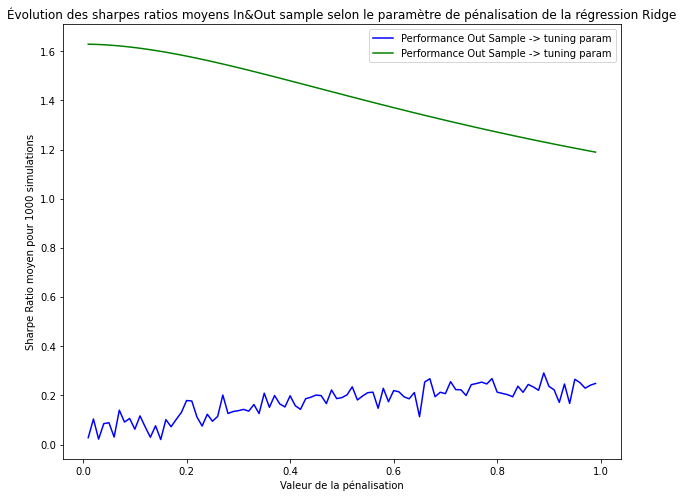

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(alphas, sharpes_mean, label = 'Performance Out Sample -> tuning param', color = 'blue')
plt.plot(alphas, sharpe_in_sample_, label = 'Performance in Sample -> tuning param', color = 'green')
plt.legend()

plt.title("Évolution des sharpes ratios moyens In&Out sample selon le paramètre de pénalisation de la régression Ridge")
plt.xlabel("Valeur de la pénalisation")
plt.ylabel('Sharpe Ratio moyen pour 1000 simulations')